In [1]:
import colorcet as cc
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.pcmci import PCMCI
from tigramite.toymodels import structural_causal_processes

from copy import deepcopy
from collections import defaultdict
from matplotlib.artist import Artist
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from graph_metrics import F1_score, matthews_correlation_coefficient, get_graph_metrics
import DSAVAR as ds
import stencil_functions as sf

In [2]:
def linear(x):
    """Linear function for SCM definitions"""
    return x

parcorr = ParCorr(significance="analytic")

In [4]:
read_data = 1
if read_data:
    DATA_FILENAME = "../data/4x4_500T_1.0sigma_0.2density_0.1minval_wMode-False.npy"
    # DATA_FILENAME = "/ascldap/users/jefnich/git/cldera/attribution/causalDiscovery/data/DSAVAR/10x10_250T_4.0sigma_0.8density_0.1minval_wMode-False.npy"
    with open(
        DATA_FILENAME,
        "rb",
    ) as f:
        spatial_coefficients, data = np.load(f, allow_pickle=True)
    GRID_SIZE = int(DATA_FILENAME.split("/")[-1].split("x")[0])
    print(spatial_coefficients)
else:
    GRID_SIZE = 4
    DEPENDENCE_DENSITY = 0.2
    MIN_VALUE = 0.1
    T = 500
    mu, sigma = (0, 1.0)  # mean and standard deviation
    ROWS = GRID_SIZE
    COLS = GRID_SIZE
    data = np.zeros((ROWS, COLS, T, 1))

    spatial_coefficients = ds.get_random_stable_coefficient_matrix(
        GRID_SIZE, DEPENDENCE_DENSITY, min_value_threshold=MIN_VALUE, verbose=1
    )

    # Run simulation
    for t in range(1, T):
        for row in range(ROWS):
            for col in range(COLS):
                from_left = spatial_coefficients[1, 0] * data[row, col - 1, t - 1, 0]
                from_right = spatial_coefficients[1, 2] * data[row, (col + 1) % ROWS, t - 1, 0]
                from_top = spatial_coefficients[0, 1] * data[row - 1, col, t - 1, 0]
                from_bottom = spatial_coefficients[2, 1] * data[(row + 1) % ROWS, col, t - 1, 0]

                from_top_left = spatial_coefficients[0, 0] * data[row - 1, col - 1, t - 1, 0]
                from_top_right = spatial_coefficients[0, 2] * data[row - 1, (col + 1) % COLS, t - 1, 0]
                from_bot_left = spatial_coefficients[2, 0] * data[(row + 1) % ROWS, col - 1, t - 1, 0]
                from_bot_right = (
                    spatial_coefficients[2, 2] * data[(row + 1) % ROWS, (col + 1) % COLS, t - 1, 0]
                )

                from_self = spatial_coefficients[1, 1] * data[row, col, t - 1, 0]

                data[row, col, t, 0] = (
                    from_self
                    + from_left
                    + from_right
                    + from_top
                    + from_bottom
                    + from_top_left
                    + from_top_right
                    + from_bot_left
                    + from_bot_right
                    + np.random.normal(mu, sigma)
                )  # increase sigma for higher magnitudes

data = data[:, :, :, 0]

[[-0.17531645  0.          0.        ]
 [ 0.          0.82236354  0.        ]
 [ 0.          0.          0.        ]]


In [5]:
########### castle #############
# concatenated_data = sf.concatenate_timeseries_nonwrapping(data, False)

# pcmci_df = pp.DataFrame(concatenated_data[:, :9])

# pcmci = PCMCI(dataframe=pcmci_df, cond_ind_test=parcorr, verbosity=1)

# selected_links=None
# link_assumptions=None
# tau_min=1
# tau_max=1
# save_iterations=False
pc_alpha=0.00001
# max_conds_dim=None
# max_combinations=1

# # Create an internal copy of pc_alpha
# _int_pc_alpha = deepcopy(pc_alpha)
# # Check if we are selecting an optimal alpha value
# select_optimal_alpha = True
# # Set the default values for pc_alpha
# if _int_pc_alpha is None:
#     _int_pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
# elif not isinstance(_int_pc_alpha, (list, tuple, np.ndarray)):
#     _int_pc_alpha = [_int_pc_alpha]
#     select_optimal_alpha = False
# # Check the limits on tau_min
# pcmci._check_tau_limits(tau_min, tau_max)
# tau_min = max(1, tau_min)
# # Check that the maximum combinations variable is correct
# if max_combinations <= 0:
#     raise ValueError("max_combinations must be > 0")
# # Implement defaultdict for all pval_max, val_max, and iterations
# pval_max = defaultdict(dict)
# val_min = defaultdict(dict)
# iterations = defaultdict(dict)


# # Set the selected links
# # _int_sel_links = self._set_sel_links(selected_links, tau_min, tau_max,
# #                                      remove_contemp=True)
# _int_link_assumptions = pcmci._set_link_assumptions(link_assumptions, 
#     tau_min, tau_max, remove_contemp=True)

# # Initialize all parents
# all_parents = dict()
# # Set the maximum condition dimension
# max_conds_dim = pcmci._set_max_condition_dim(max_conds_dim,
#                                             tau_min, tau_max)


# all_parents = {i: {'parents': [],
#     'val_min': {(j, -1): 0 for j in range(9)}, 
#     'pval_max': {(k, -1): 1 for k in range(9)},
#     'iterations':{}} for i in range(9)}
# # all_parents[4] = pcmci._run_pc_stable_single(4, link_assumptions_j=_int_link_assumptions[4], pc_alpha=pc_alpha)
# import pc_stable_single
# all_parents[4] = pc_stable_single.PC_stable_single(pcmci_df, parcorr)._run_pc_stable_single(4, pc_alpha=pc_alpha)


# # Make SCM and val_matrix for plotting
# dependence_threshold = 0.25
# SCM = {}

# for key in all_parents.keys():
#     SCM[key] = []
#     parents_list = [parent[0] for parent in all_parents[key]["parents"]]
#     for parent in parents_list:
#         coefficient = all_parents[key]["val_min"][(parent, -1)]
#         if abs(coefficient) < dependence_threshold:
#             coefficient = 0
#         SCM[key].append(((parent, -1), coefficient, linear))

# graph = structural_causal_processes.links_to_graph(SCM)


# v_matrix = np.zeros(graph.shape)
# for row in range(v_matrix.shape[0]):
#     if len(SCM[row]) != 0:
#         for dependence in SCM[row]:
#             coefficient = dependence[1]
#             v_matrix[dependence[0][0], row, 1] = coefficient

graph, v_matrix = sf.CaStLe(data=data, cond_ind_test=parcorr, pc_alpha=pc_alpha)



# ############## /castle ################

# parents = sf.get_parents(graph, val_matrix=v_matrix, include_lagzero_parents=True, output_val_matrix=True)
x_pos = list(np.array([[i for i in range(3)] for j in range(3)]).flatten())
y_pos = [i for i in range(3) for j in range(3)]
y_pos.reverse()
node_positions = {
    "x": x_pos,
    "y": y_pos,
}
tp.plot_graph(
    val_matrix=v_matrix,#.round(),
    graph=graph,
    # figsize=(12, 10),
    link_label_fontsize=0.0,
    # show_colorbar=False,
    var_names=[""] * 9,
    # var_names=var_names,
    node_pos=node_positions,
    link_colorbar_label="Cross-Dependence (MCI)",
    node_colorbar_label="Inter-Dependence (MCI)",
)

IndexError: index 4 is out of bounds for axis 0 with size 4

In [ ]:
center_parents = sf.get_parents(graph, val_matrix=v_matrix, include_lagzero_parents=True)[4]
center_parents

[(4, -1), (6, -1)]

In [ ]:
reconstructed_full_graph = sf.get_expanded_graph(center_parents, GRID_SIZE)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

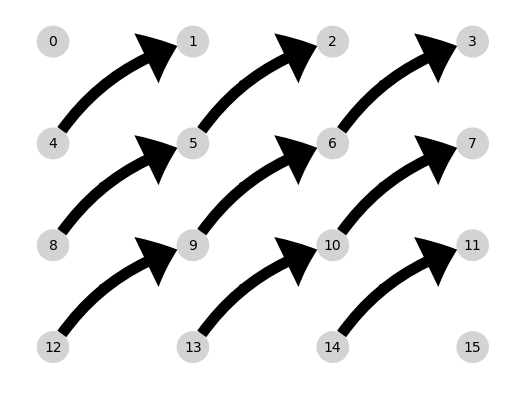

In [ ]:
fig_ax = plt.subplots()
fig, ax = fig_ax
x_pos = list(np.array([[i for i in range(GRID_SIZE)] for j in range(GRID_SIZE)]).flatten())
y_pos = [i for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
y_pos.reverse()
node_positions = {
    "x": x_pos,
    "y": y_pos,
}
tp.plot_graph(
    fig_ax=fig_ax,
    graph=reconstructed_full_graph,
    # graph=true_graph,
    figsize=(16, 16),
    # var_names=var_names,
    link_label_fontsize=0.,
    node_pos=node_positions,
)

In [ ]:
ndm = sf.get_ndm(center_parents)

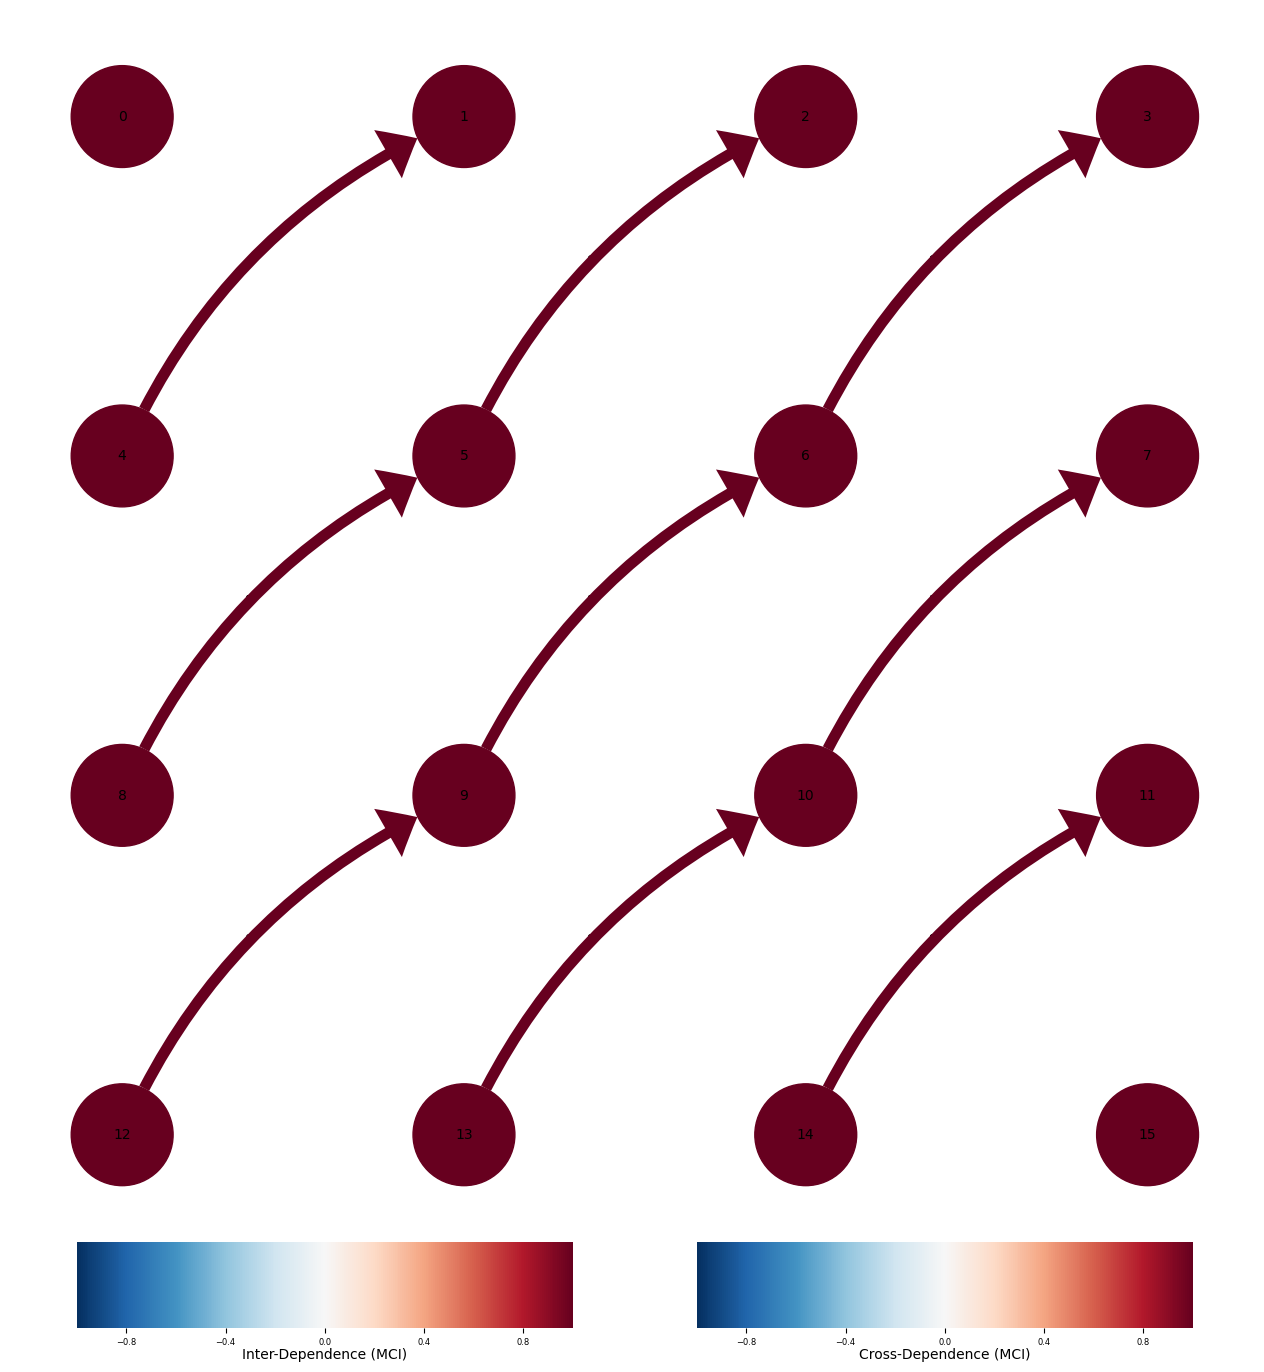

In [ ]:
color_dependencies = 1

# Construct nonwrapping full graph from NDM of stencil
reconstructed_dynamics_matrix_nw = ds.create_nonwrapping_coefficient_matrix(ndm, GRID_SIZE)
reconstructed_full_graph_nw, reconst_val_matrix_nw = ds.get_graph_from_coefficient_matrix(
    reconstructed_dynamics_matrix_nw, return_val_matrix=True
)

fig_ax = plt.subplots(figsize=(16,16))
fig, ax = fig_ax
x_pos = list(np.array([[i for i in range(GRID_SIZE)] for j in range(GRID_SIZE)]).flatten())
y_pos = [i for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
y_pos.reverse()
node_positions = {
    "x": x_pos,
    "y": y_pos,
}
if color_dependencies:
    tp.plot_graph(
        fig_ax=fig_ax,
        graph=reconstructed_full_graph_nw,
        val_matrix=reconst_val_matrix_nw,
        # graph=true_graph,
        figsize=(16, 16),
        # var_names=var_names,
        link_label_fontsize=0.,
        node_pos=node_positions,
        link_colorbar_label="Cross-Dependence (MCI)",
        node_colorbar_label="Inter-Dependence (MCI)",
    )
else:
    cmap_N = 256
    white_vals = np.ones((cmap_N, 4))
    black_vals = np.zeros((cmap_N, 4))
    white_cmap = ListedColormap(white_vals)
    black_cmap = ListedColormap(black_vals)
    tp.plot_graph(
        fig_ax=fig_ax,
        graph=reconstructed_full_graph_nw,
        val_matrix=reconst_val_matrix_nw.round(),
        link_label_fontsize=0.,
        arrowhead_size=80,
        cmap_edges=black_cmap,
        cmap_nodes="binary",
        # alpha=0.5,
        show_colorbar=False,
        var_names=[""]*16,
        node_pos=node_positions,
    )

In [ ]:
data_flat = data.reshape((data.shape[0]**2, data.shape[2])).transpose()
dict_list = []
for i in range(data_flat.shape[1]):
    for j in range(data_flat.shape[0]):
        data_dict = {}
        data_dict["Cell"] = i
        data_dict["Time Step"] = j
        data_dict["Data"] = data_flat[j, i]
        dict_list.append(data_dict)
df = pd.DataFrame(data=dict_list)
df

,Cell,Time Step,Data
0,0,0,0.000000
1,0,1,-0.007143
2,0,2,-1.106836
3,0,3,-0.784719
4,0,4,-1.426064
...,...,...,...
7995,15,495,11.275300
7996,15,496,9.620672
7997,15,497,10.119083
7998,15,498,8.725370


In [ ]:
c_palette = sns.color_palette(cc.glasbey, n_colors=GRID_SIZE**2,)
alpha=1.0
linewidth=2

sns.set_context("poster")
sns.set_style('white')

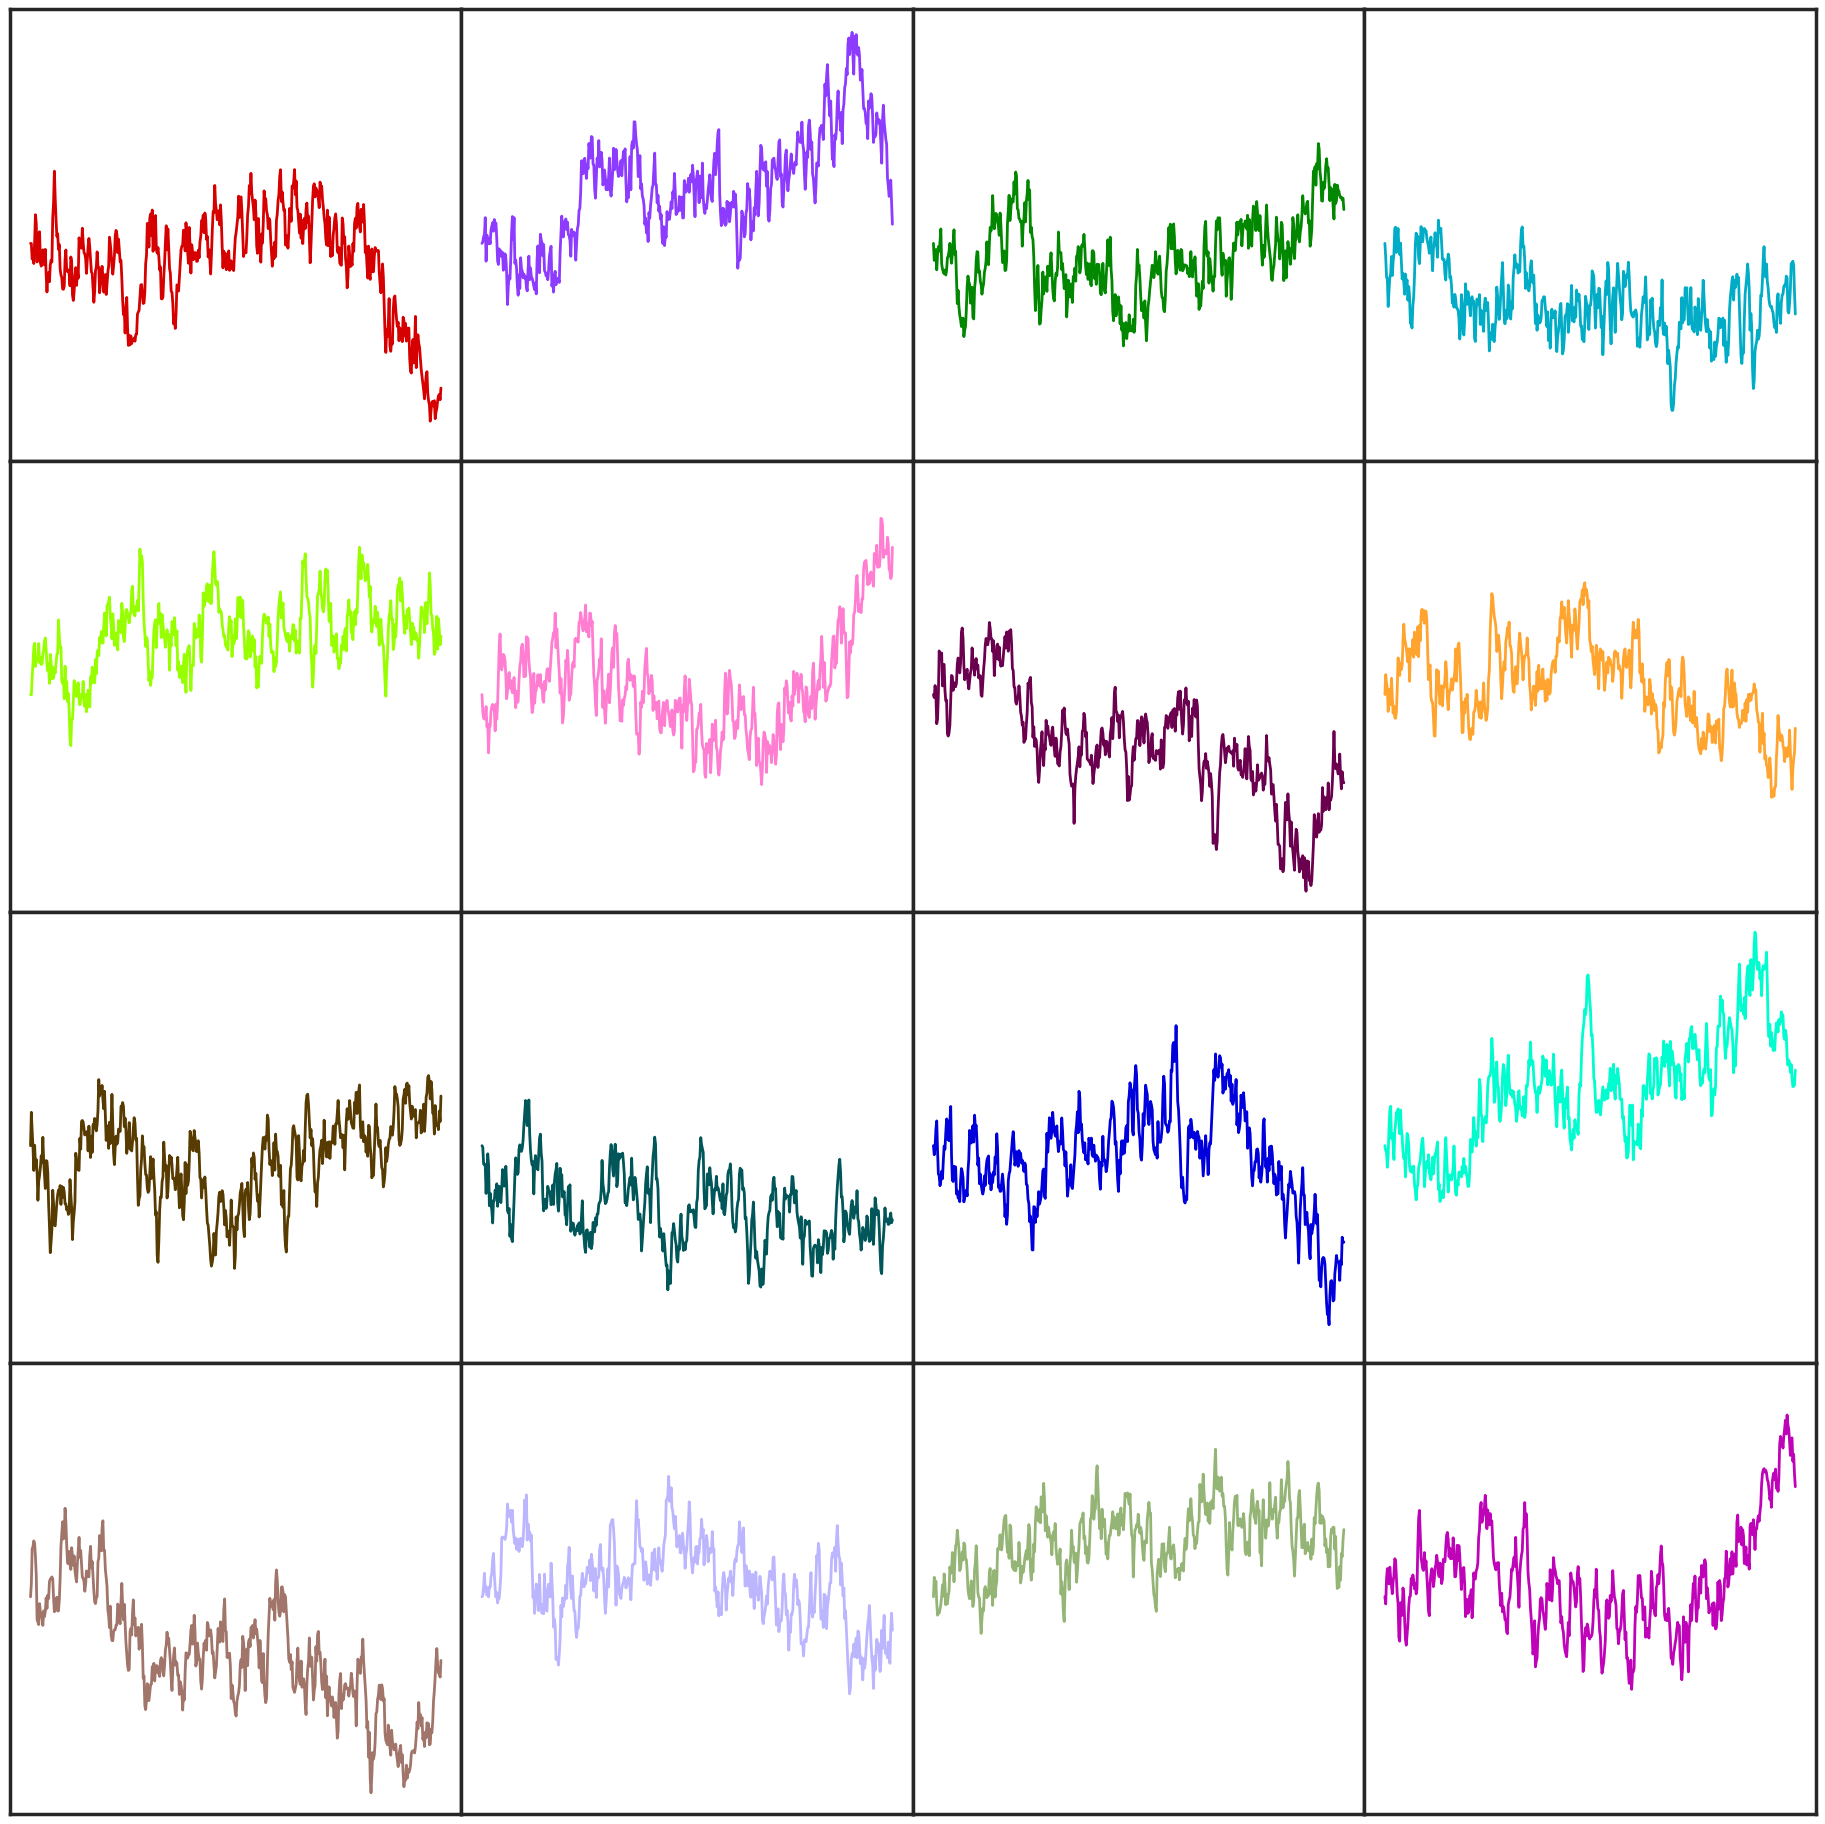

In [ ]:
showlabels = False
g = sns.relplot(data=df, x="Time Step", y="Data", col="Cell", col_wrap=GRID_SIZE, kind="line", hue="Cell", palette=c_palette, alpha=alpha, linewidth=linewidth)
g.set_titles("")
if showlabels:
    g.set_xlabels("Time Step")
    g.set_ylabels("Aerosol Optical Depth")
else:
    g.set_xlabels("")
    g.set_ylabels("")
    sns.despine(g, top=False, bottom=False, left=False, right=False)
    g.set(xticklabels=[])
    g.set(yticklabels=[])
    g.fig.subplots_adjust(wspace=0., hspace=0.)
# g.despine()
# if not showlabels:
#     for col in range(GRID_SIZE**2):
#         g.facet_axis(0,col).axis("off")
    
# for ax in g.axes.flatten(): # Loop directly on the flattened axes 
#     for spine in ax.spines.values():
#         spine.set_visible(True) # You have to first turn them on
#         spine.set_color('black')
#         spine.set_linewidth(4)
g._legend.remove()
# g.tight_layout()
plt.savefig('4x4TS.pdf', transparent=True)

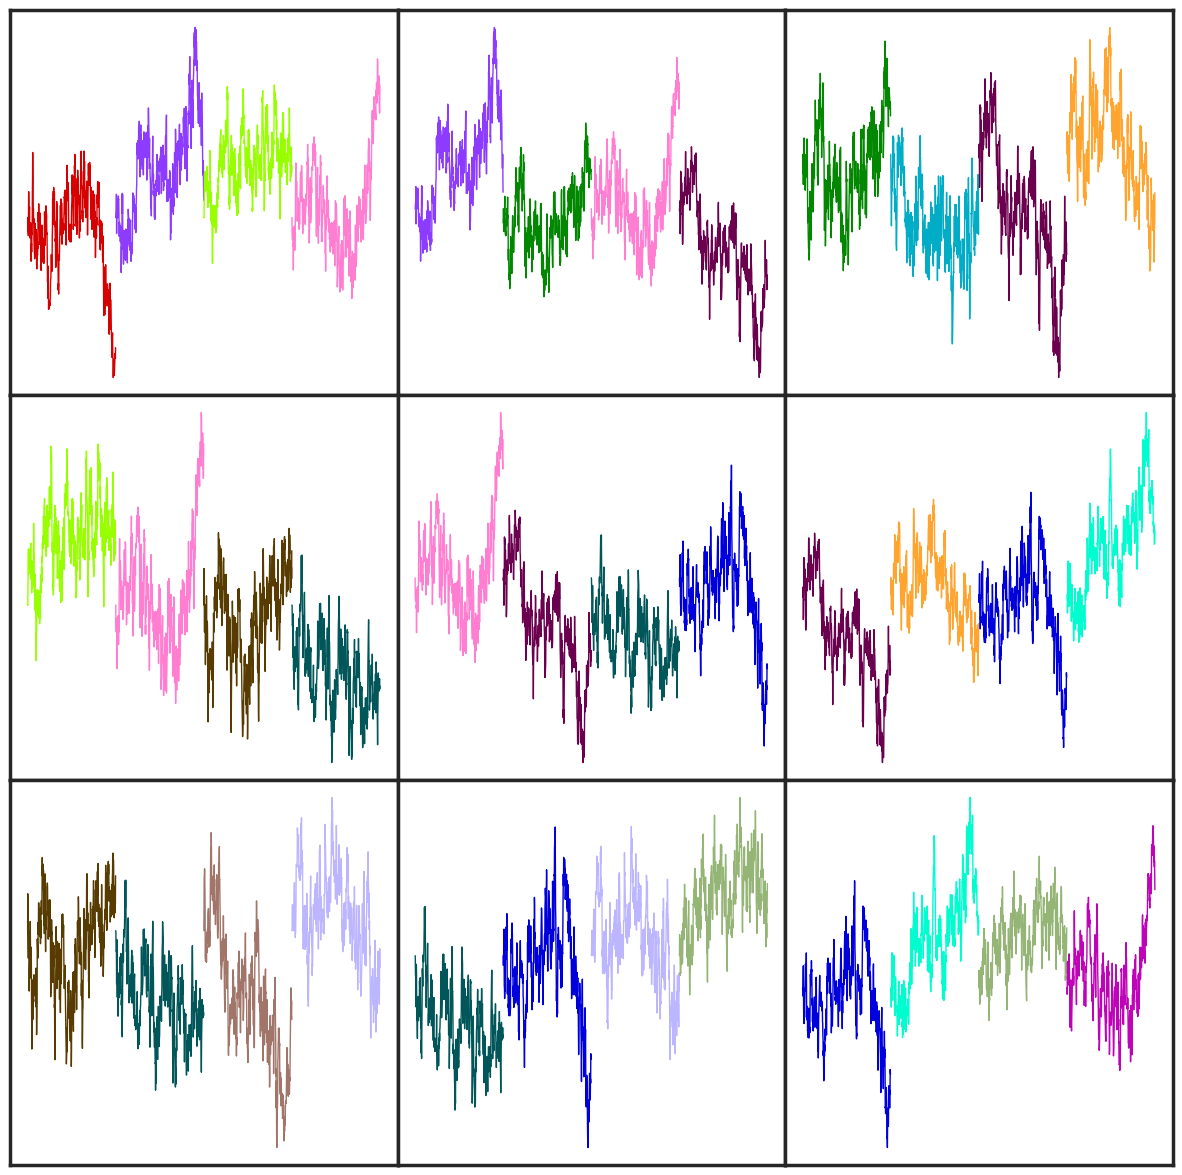

In [ ]:
# fig, ax = plt.subplots()
# fig = plt.figure(figsize=(15,15))
fig, axs = plt.subplots(3,3, figsize=(15,15))
labels=showlabels
# color_list = np.array(c_palette)
color_list = np.array(c_palette.as_hex()).reshape((GRID_SIZE, GRID_SIZE))
GRID_SIZE = data.shape[0]
# create one cell buffer such that all cells evaluated have neighbors on all sides
ROW_RANGE = range(1, GRID_SIZE - 1)
# create one cell buffer such that all cells evaluated have neighbors on all sides
COL_RANGE = range(1, GRID_SIZE - 1)

# idx = 0
start = 0
stop = start
# cell_num = 0
for row in ROW_RANGE:
    for col in COL_RANGE:
        stop = data.shape[2] + start

        from_left = data[row, col - 1, :]
        from_right = data[row, col + 1, :]
        from_top = data[row - 1, col, :]
        from_bottom = data[row + 1, col, :]
        from_top_left = data[row - 1, col - 1, :]
        from_top_right = data[row - 1, col + 1, :]
        from_bot_left = data[row + 1, col - 1, :]
        from_bot_right = data[row + 1, col + 1, :]
        from_self = data[row, col, :]

        plt.subplot(3, 3, 1)
        f = sns.lineplot(x=range(start, stop), y=from_top_left, color=color_list[row - 1, col - 1], alpha=alpha, linewidth=linewidth)
        if labels:
            f.set(xticklabels=[], xlabel=None, ylabel="Aerosol Optical Depth")#, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=True)  # remove the ticks
        else:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        plt.subplot(3, 3, 2)
        f = sns.lineplot(x=range(start, stop), y=from_top, color=color_list[row - 1, col], alpha=alpha, linewidth=linewidth)
        if labels:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        else:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        plt.subplot(3, 3, 3)
        f = sns.lineplot(x=range(start, stop), y=from_top_right, color=color_list[row - 1, col + 1], alpha=alpha, linewidth=linewidth)
        if labels:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        else:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        plt.subplot(3, 3, 4)
        f = sns.lineplot(x=range(start, stop), y=from_left, color=color_list[row, col - 1], alpha=alpha, linewidth=linewidth)
        if labels:
            f.set(xticklabels=[], xlabel=None, ylabel="Aerosol Optical Depth")#, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=True)  # remove the ticks
        else:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        plt.subplot(3, 3, 5)
        f = sns.lineplot(x=range(start, stop), y=from_self, color=color_list[row, col], alpha=alpha, linewidth=linewidth)
        if labels:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        else:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        plt.subplot(3, 3, 6)
        f = sns.lineplot(x=range(start, stop), y=from_right, color=color_list[row, col + 1], alpha=alpha, linewidth=linewidth)
        if labels:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        else:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        plt.subplot(3, 3, 7)
        f = sns.lineplot(x=range(start, stop), y=from_bot_left, color=color_list[row + 1, col - 1], alpha=alpha, linewidth=linewidth)
        if labels:
            f.set(yticklabels=[], xlabel="Time Step", ylabel="Aerosol Optical Depth")#, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=True)  # remove the ticks
        else:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        plt.subplot(3, 3, 8)
        f = sns.lineplot(x=range(start, stop), y=from_bottom, color=color_list[row + 1, col], alpha=alpha, linewidth=linewidth)
        if labels:
            f.set(yticklabels=[], xlabel="Time Step")
            f.tick_params(bottom=False, left=False)  # remove the ticks
        else:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        plt.subplot(3, 3, 9)
        f = sns.lineplot(x=range(start, stop), y=from_bot_right, color=color_list[row + 1, col + 1], alpha=alpha, linewidth=linewidth)
        if labels:
            f.set(yticklabels=[], xlabel="Time Step")
            f.tick_params(bottom=False, left=False)  # remove the ticks
        else:
            f.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
            f.tick_params(bottom=False, left=False)  # remove the ticks
        
        start = stop
        

for ax in axs.flat:
    if labels:
        sns.despine(ax=ax)
    else:
        sns.despine(ax=ax, top=False, bottom=False, left=False, right=False)
        # ax.set(xticklabels=[])
        # ax.set(yticklabels=[])
        # sns.despine(bottom=True, left=True, ax=ax)
    # sns.despine(left=not ax.get_subplotspec().is_first_col(), ax=ax)
    # sns.despine(bottom=not ax.get_subplotspec().is_last_row(), left=not ax.get_subplotspec().is_first_col(), ax=ax)
# plt.tight_layout()
plt.subplots_adjust(wspace=0., hspace=0.)
plt.savefig('3x3TS.pdf', transparent=True)

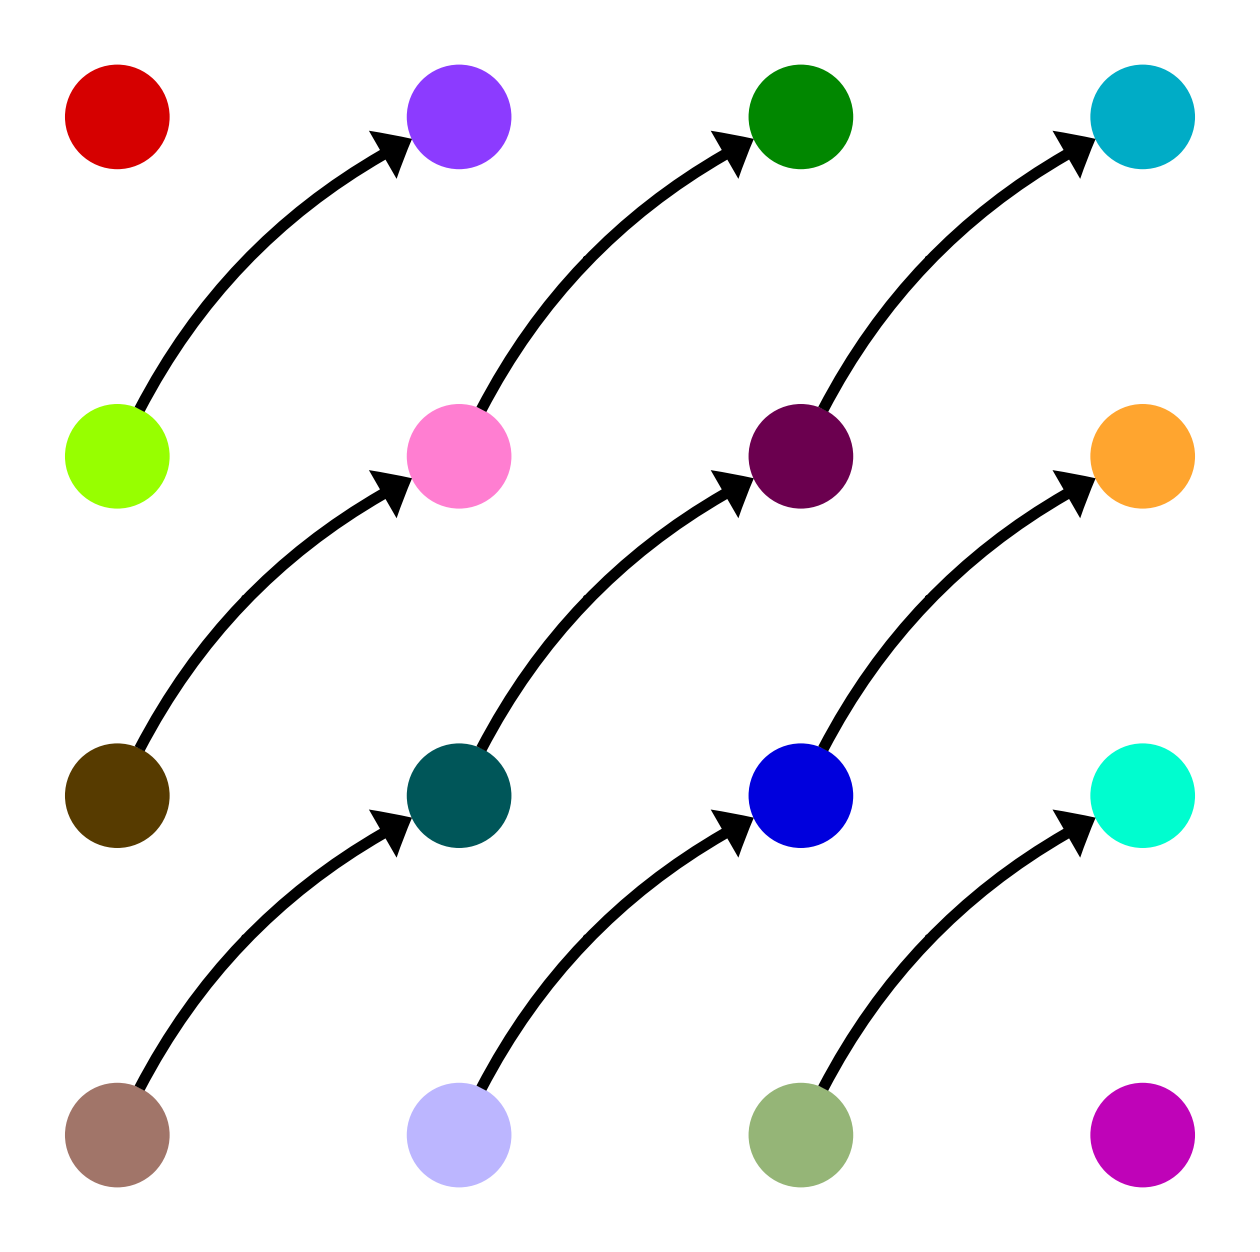

In [ ]:
# Construct nonwrapping full graph from NDM of stencil
reconstructed_dynamics_matrix_nw = ds.create_nonwrapping_coefficient_matrix(ndm, GRID_SIZE)
reconstructed_full_graph_nw, reconst_val_matrix_nw = ds.get_graph_from_coefficient_matrix(
    reconstructed_dynamics_matrix_nw, return_val_matrix=True
)

fig_ax = plt.subplots(figsize=(16,16))
fig, ax = fig_ax
x_pos = list(np.array([[i for i in range(GRID_SIZE)] for j in range(GRID_SIZE)]).flatten())
y_pos = [i for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
y_pos.reverse()
node_positions = {
    "x": x_pos,
    "y": y_pos,
}
tp.plot_graph(
    fig_ax=fig_ax,
    graph=reconstructed_full_graph_nw,
    # graph=true_graph,
    figsize=(16, 16),
    var_names=[""] * GRID_SIZE**2,
    # var_names=var_names,
    link_label_fontsize=0.,
    node_pos=node_positions,
)

c_idx = 0
for item in ax.get_children():
    if isinstance(item, matplotlib.patches.Ellipse):
        color = c_palette[c_idx]
        item.set_color(color)
        c_idx += 1

In [ ]:
# Generate specific example. Comment this out to continue the analysis above.
# ndm = ds.get_random_stable_coefficient_matrix(
#         GRID_SIZE, 0.2, min_value_threshold=0.1
#     )
ndm = np.array([
    [0., 0., 0.],
    [0.8, 0., 0.],
    [-0.8, 0., 0.],
])
ndm = np.array([
    [0., 0., 0.],
    [0., 0., 0.],
    [0., 0., 0.],
])
print(ndm)
stencil_graph, stencil_v_matrix = sf.get_stencil_graph(ndm, return_val_matrix=True)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


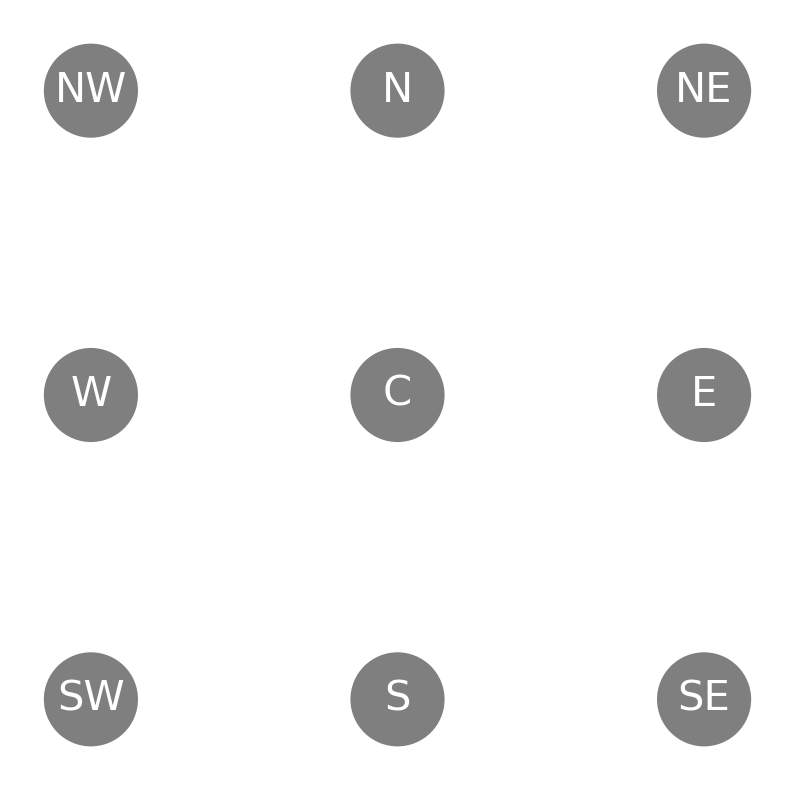

In [ ]:
fig_ax = plt.subplots(figsize=(10,10))
fig, ax = fig_ax

x_pos = list(np.array([[i for i in range(3)] for j in range(3)]).flatten())
y_pos = [i for i in range(3) for j in range(3)]
y_pos.reverse()
node_positions = {
    "x": x_pos,
    "y": y_pos,
}

var_names = ["NW", "N", "NE", "W", "C", "E", "SW", "S", "SE"]
cmap_N = 256
white_vals = np.ones((cmap_N, 4))
black_vals = np.zeros((cmap_N, 4))
white_cmap = ListedColormap(white_vals)
black_cmap = ListedColormap(black_vals)

tp.plot_graph(
    fig_ax=fig_ax,
    graph=stencil_graph,
    val_matrix=stencil_v_matrix,
    link_label_fontsize=0.,
    node_label_size=30,
    arrowhead_size=80,
    # cmap_edges=black_cmap,
    cmap_nodes="binary",
    # alpha=0.5,
    show_colorbar=False,
    # var_names=[""]*9,
    var_names=var_names,
    node_pos=node_positions,
    # link_colorbar_label="Cross-Dependence (MCI)",
    # node_colorbar_label="Inter-Dependence (MCI)",
)

for item in ax.get_children():
    if isinstance(item, matplotlib.text.Text):
        item.set_color("w")
        if item.get_text() == "1":
            Artist.set_visible(item, False)
plt.savefig('stencil_ex_no_links.pdf', transparent=True)
# plt.savefig('stencil_ex.pdf', transparent=True)

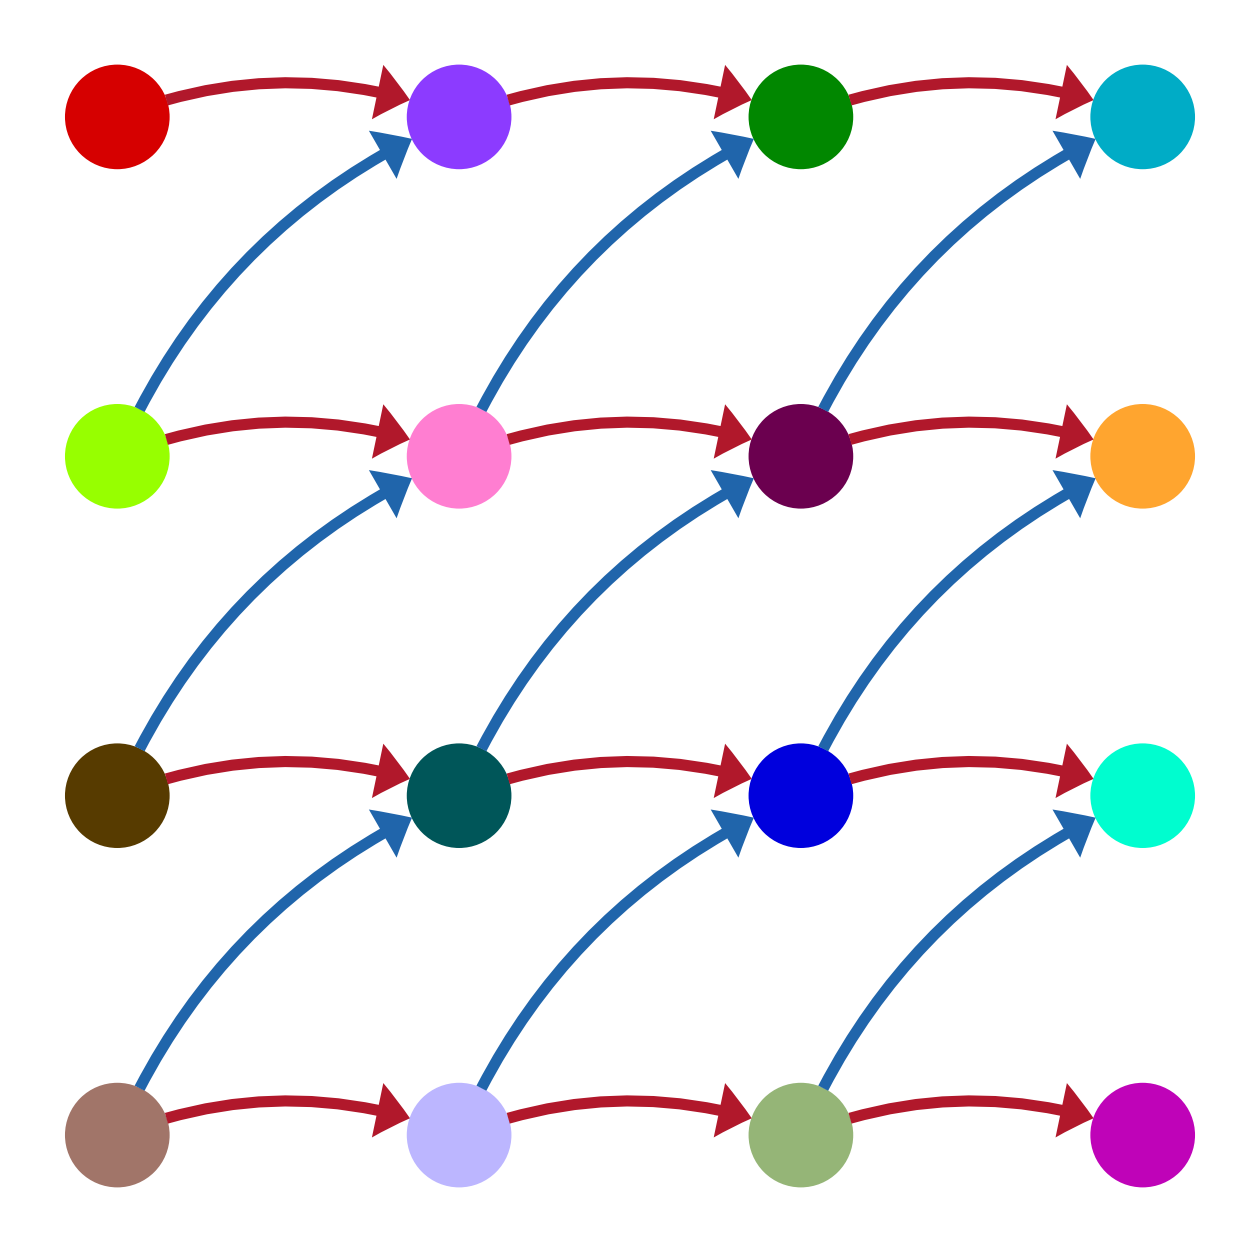

In [ ]:
# Construct nonwrapping full graph from NDM of stencil
reconstructed_dynamics_matrix_nw = ds.create_nonwrapping_coefficient_matrix(ndm, GRID_SIZE)
reconstructed_full_graph_nw, reconst_val_matrix_nw = ds.get_graph_from_coefficient_matrix(
    reconstructed_dynamics_matrix_nw, return_val_matrix=True
)

fig_ax = plt.subplots(figsize=(16,16))
fig, ax = fig_ax
x_pos = list(np.array([[i for i in range(GRID_SIZE)] for j in range(GRID_SIZE)]).flatten())
y_pos = [i for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
y_pos.reverse()
node_positions = {
    "x": x_pos,
    "y": y_pos,
}
tp.plot_graph(
    fig_ax=fig_ax,
    graph=reconstructed_full_graph_nw,
    val_matrix=reconst_val_matrix_nw,
    show_colorbar=False,
    figsize=(16, 16),
    var_names=[""] * GRID_SIZE**2,
    # var_names=var_names,
    link_label_fontsize=0.,
    node_pos=node_positions,
)

c_idx = 0
for item in ax.get_children():
    if isinstance(item, matplotlib.text.Text):
        item.set_color("w")
        if item.get_text() == "1":
            Artist.set_visible(item, False)
    if isinstance(item, matplotlib.patches.Ellipse):
        color = c_palette[c_idx]
        item.set_color(color)
        c_idx += 1
plt.savefig('expanded_stencil_ex.pdf', transparent=True)

In [ ]:
# fig_ax = plt.subplots(figsize=(16,16))
# fig, ax = fig_ax

# showlabels = True
# g = sns.relplot(data=df, x="Time Step", y="Data", col="Cell", col_wrap=GRID_SIZE, kind="line", hue="Cell", palette=c_palette, alpha=alpha)
# g.set_titles("")
# if showlabels:
#     g.set_xlabels("Time Step")
#     g.set_ylabels("Aerosol Optical Depth")
# else:
#     g.set_xlabels("")
#     g.set_ylabels("")
# # g.despine()
# if not showlabels:
#     for col in range(GRID_SIZE**2):
#         g.facet_axis(0,col).axis("off")
# # for ax in g.axes.flatten(): # Loop directly on the flattened axes 
# #     for spine in ax.spines.values():
# #         spine.set_visible(True) # You have to first turn them on
# #         spine.set_color('black')
# #         spine.set_linewidth(4)
# g._legend.remove()
# # g.tight_layout()
# # plt.savefig('4x4TS.png', transparent=True)


# # Construct nonwrapping full graph from NDM of stencil
# reconstructed_dynamics_matrix_nw = ds.create_nonwrapping_coefficient_matrix(ndm, GRID_SIZE)
# reconstructed_full_graph_nw, reconst_val_matrix_nw = ds.get_graph_from_coefficient_matrix(
#     reconstructed_dynamics_matrix_nw, return_val_matrix=True
# )


# x_pos = list(np.array([[i for i in range(GRID_SIZE)] for j in range(GRID_SIZE)]).flatten())
# y_pos = [i for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
# y_pos.reverse()
# node_positions = {
#     "x": x_pos,
#     "y": y_pos,
# }
# tp.plot_graph(
#     fig_ax=fig_ax,
#     graph=reconstructed_full_graph_nw,
#     # graph=true_graph,
#     figsize=(16, 16),
#     var_names=[""] * GRID_SIZE**2,
#     # var_names=var_names,
#     link_label_fontsize=0.,
#     node_pos=node_positions,
# )

# c_idx = 0
# for item in ax.get_children():
#     if isinstance(item, matplotlib.patches.Ellipse):
#         color = c_palette[c_idx]
#         item.set_color(color)
#         c_idx += 1